# Binary classification with TensorFlow neural network

Example notebook for chest x-ray classification model

Original notebook: https://github.com/guimou/datapipelines/blob/main/demos/xray/utils/x-ray-predict-pneumonia-keras-training.ipynb

Dataset: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia.
Please ensure you made available the dataset in this pod prior to executing this notebook. You can achieve by either performing an upload using jupyter or by running the download function from the s3-buckets notebook (providing you uploaded using aws cli tool the dataset to the train-test-validation bucket.

### Imports

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, MaxPool2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### Verify data directories structure

In [2]:
print(os.listdir("."))

['create_notifications.ipynb', 'requirements.txt', 's3-buckets.ipynb', 'x-ray-predict-pneumonia-tf-training.ipynb', '.ipynb_checkpoints', 'best_model_xray.h5']


In [3]:
print(os.listdir("../dataset"))

print(os.listdir("../dataset/test"))

print(os.listdir("../dataset/train/"))

print(os.listdir("../dataset/val/"))

['test', 'train', 'val']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


### Check an image in the "NORMAL" training set

NORMAL


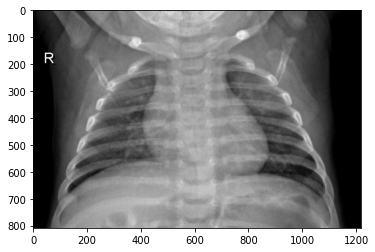

In [4]:
img_name = 'NORMAL2-IM-0588-0001.jpeg'
img_normal = load_img('../dataset/train/NORMAL/' + img_name)

print('NORMAL')
plt.imshow(img_normal)
plt.show()

### Check an image in the PNEUMONIA training set

PNEUMONIA


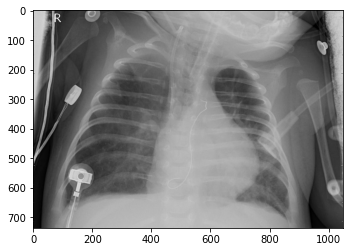

In [5]:
img_name = 'person63_bacteria_306.jpeg'
img_pneumonia = load_img('../dataset/train/PNEUMONIA/' + img_name)

print('PNEUMONIA')
plt.imshow(img_pneumonia)
plt.show()

### Initialize variables

In [6]:
# dimensions of our images.
img_width, img_height = 150, 150

In [7]:
train_data_dir = '../dataset/train'
validation_data_dir = '../dataset/val'
test_data_dir = '../dataset/test'

nb_train_samples = 5217
nb_validation_samples = 17
epochs = 20
batch_size = 16

In [8]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

### Create (Sequential) Model

In [9]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

2023-02-08 21:47:26.995038: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Check information about the model

In [10]:
model.layers

In [11]:
model.input

<KerasTensor: shape=(None, 150, 150, 3) dtype=float32 (created by layer 'conv2d_input')>

In [12]:
model.output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>

### Compile the model

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
rl_on_plateau = ReduceLROnPlateau(monitor='accuracy', patience = 3, verbose=1, factor=0.3, min_lr=0.0001)
# mc = ModelCheckpoint('best_model_xray.h5', monitor='val_loss', mode='min', save_best_only=True)
mc = ModelCheckpoint('best_model_xray.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [14]:
model.compile(loss='binary_crossentropy',
              #optimizer='rmsprop',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

### Upload images from the different sets

In [15]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [16]:
# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [17]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=42
    )

Found 5216 images belonging to 2 classes.


In [18]:
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=42
    )    

Found 16 images belonging to 2 classes.


#### The test generator must not be shuffled to be able to calculate the confusion matrix

In [19]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
    )    

Found 624 images belonging to 2 classes.


### Fit the model (checkpoint will be created for the model with best validation accuracy)

In [20]:
history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size, 
    callbacks = [rl_on_plateau, mc]
    )

Epoch 1/20
326/326 [==============================] - 58s 177ms/step - loss: 0.3277 - accuracy: 0.8526 - val_loss: 1.6469 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/20
326/326 [==============================] - 55s 170ms/step - loss: 0.2313 - accuracy: 0.9055 - val_loss: 1.1374 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 3/20
326/326 [==============================] - 55s 169ms/step - loss: 0.2102 - accuracy: 0.9206 - val_loss: 1.6827 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 4/20
326/326 [==============================] - 55s 168ms/step - loss: 0.1966 - accuracy: 0.9222 - val_loss: 0.8282 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 5/20
326/326 [==============================] - 55s 168ms/step - loss: 0.1912 - accuracy: 0.9260 - val_loss: 1.0009 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 6/20
326/326 [==============================] - 54s 167ms/step - loss: 0.1811 - accuracy: 0.9273 - val_loss: 1.1298 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 7/20
326/326 [========

### Visualize the training results

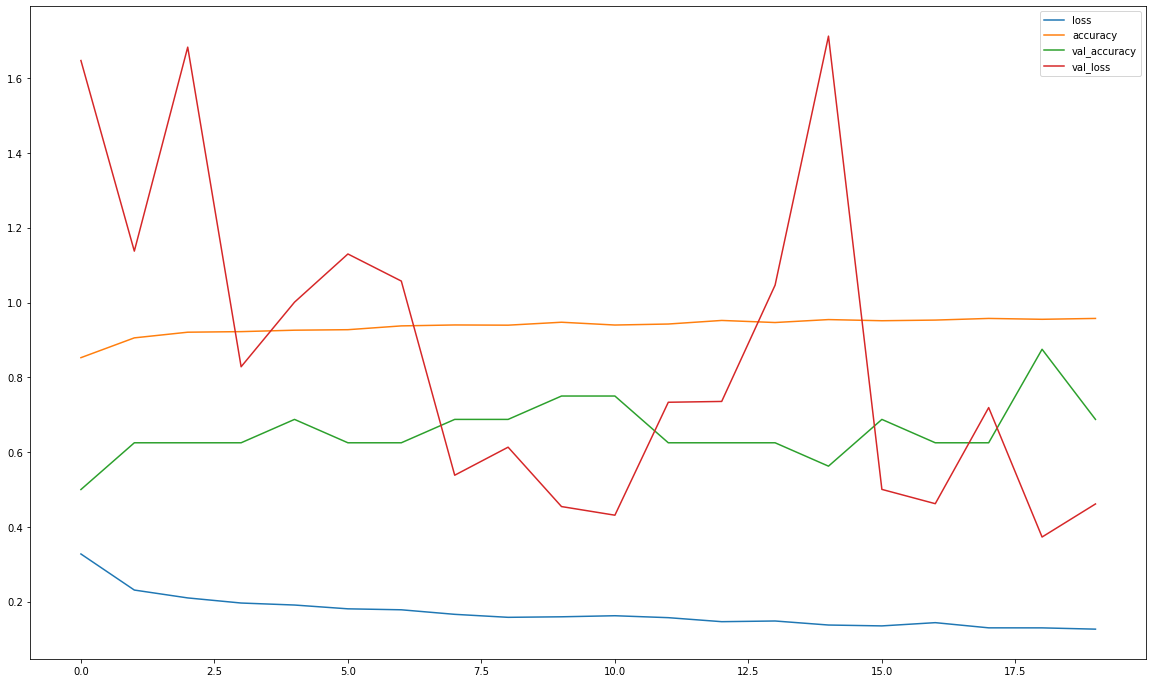

In [21]:
plt.figure(figsize=(20,12))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

### Save the model at the end of the training (weights + complete model)

In [22]:
model.save_weights('first_try.h5')

In [23]:
model.save('pneumonia_model.h5')

### Evaluate the models

#### Model 1: model with highest training accuracy (end of training cycle)

In [24]:
# evaluate the model
test_generator.reset()
scores = model.evaluate(test_generator, verbose=1)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

39/39 [==============================] - 3s 80ms/step - loss: 0.3457 - accuracy: 0.9022

accuracy: 90.22%


In [25]:
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)

39/39 [==============================] - 3s 79ms/step


In [26]:
from sklearn.metrics import classification_report,confusion_matrix, matthews_corrcoef

In [27]:
labels = (test_generator.class_indices)
labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [28]:
y_pred = np.rint(predictions)

In [29]:
y_true = test_generator.classes

In [30]:
print(classification_report(y_true, y_pred, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.93      0.80      0.86       234
Pneumonia (Class 1)       0.89      0.96      0.92       390

           accuracy                           0.90       624
          macro avg       0.91      0.88      0.89       624
       weighted avg       0.90      0.90      0.90       624



In [31]:
matthews_corrcoef(y_true, y_pred)

0.790475363419243

In [32]:
import seaborn as sns

<AxesSubplot:>

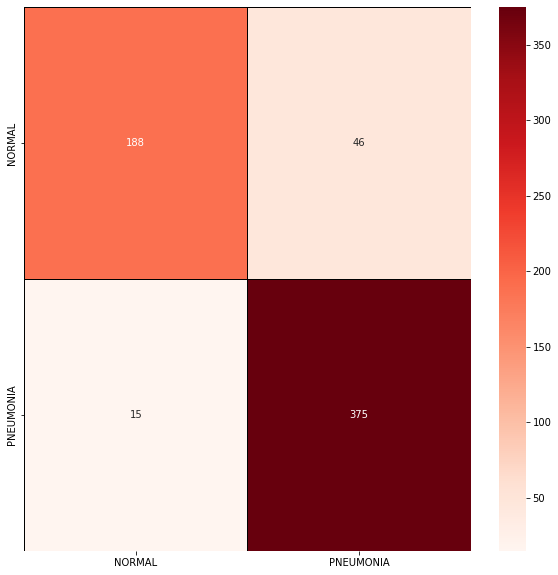

In [33]:
cm = confusion_matrix(y_true,y_pred)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm, cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='', xticklabels = labels, yticklabels = labels)

#### Model2: model checkpoint (with highest training validation accuracy)

In [34]:
import tensorflow as tf

In [35]:
model_best = tf.keras.models.load_model('/home/arthur/Downloads/best_model_xray.h5')

In [36]:
# evaluate the model
test_generator.reset()
scores = model_best.evaluate(test_generator, verbose=1)
print("\n%s: %.2f%%" % (model_best.metrics_names[1], scores[1]*100))

39/39 [==============================] - 3s 79ms/step - loss: 0.2325 - accuracy: 0.9167

accuracy: 91.67%


In [37]:
test_generator.reset()
predictions2 = model_best.predict(test_generator, verbose=1)

39/39 [==============================] - 3s 78ms/step


In [38]:
y_pred2 = np.rint(predictions2)

In [39]:
print(classification_report(y_true, y_pred2, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.89      0.88      0.89       234
Pneumonia (Class 1)       0.93      0.94      0.93       390

           accuracy                           0.92       624
          macro avg       0.91      0.91      0.91       624
       weighted avg       0.92      0.92      0.92       624



In [40]:
matthews_corrcoef(y_true, y_pred2)

0.8219370882606586

<AxesSubplot:>

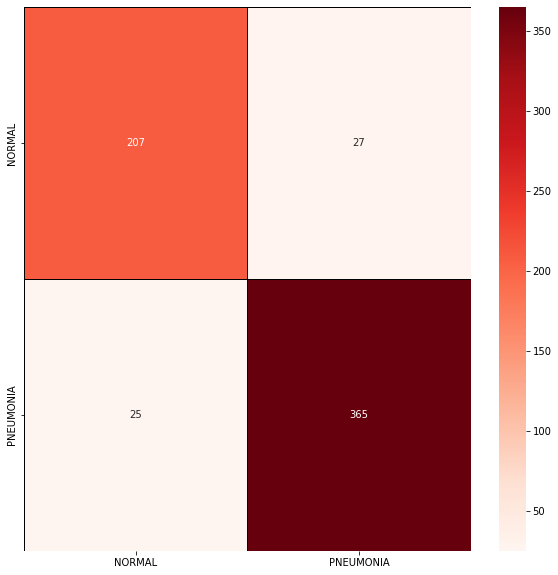

In [41]:
cm2 = confusion_matrix(y_true,y_pred2)
cm2 = pd.DataFrame(cm2 , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm2, cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='', xticklabels = labels, yticklabels = labels)

### Export the model to ONNX format and then deploy it inside RHODS' Model Mesh Service

In [42]:
import tf2onnx

In [43]:
model_onnx, _ = tf2onnx.convert.from_keras(model_best, output_path='tf_xraydemo.onnx')

2023-02-09 11:19:14.821753: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-02-09 11:19:14.821827: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-02-09 11:19:14.823294: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1149] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.004ms.
  function_optimizer: function_optimizer did nothing. time = 0ms.

2023-02-09 11:19:14.867032: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-02-09 11:19:14.867153: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-02-09 11:19:14.878125: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1149] O

In [73]:
import boto3
import botocore

In [74]:
aws_access_key_id = 'XXXX'
aws_secret_access_key = 'XXX'
region_name = 'us-east-2'

endpoint_url = 'https://s3-openshift-storage.apps.cluster-r5lsb.r5lsb.sandbox1121.opentlc.com/'

In [ ]:
#S3 AWS client
s3_aws = boto3.client(service_name = 's3',
                      aws_access_key_id = aws_access_key_id,
                      aws_secret_access_key = aws_secret_access_key,
                      region_name = region_name)

In [75]:
#S3 Rados GW client
s3_rados = boto3.client(service_name = 's3',
                      aws_access_key_id = aws_access_key_id,
                      aws_secret_access_key = aws_secret_access_key,
                      region_name = 'us-east-2',
                      endpoint_url = endpoint_url,
                      config = botocore.client.Config(signature_version = 's3'))

In [78]:
s3_rados.upload_file('tf_xraydemo.onnx', 'my-bucket', 'xraydemo/tf_xraydemo.onnx')

In [ ]:
response = s3_rados.list_buckets()

# Output the bucket names
print('Existing buckets:')
for bucket in response['Buckets']:
    print(f'  {bucket["Name"]}')
    print(f'{bucket}')

In [ ]:
s3_resource = boto3.resource(service_name= 's3',
                                 endpoint_url = endpoint_url,
                                 aws_access_key_id = aws_access_key_id,
                                 aws_secret_access_key = aws_secret_access_key,
                                 region_name = region_name,
                                 config=botocore.client.Config(signature_version = 's3')
                                )
my_bucket = s3_resource.Bucket('mlasp-3920f118-2b70-4088-9f70-25121a15b499')

for my_bucket_object in my_bucket.objects.all():
    print(my_bucket_object.key)

### Test the model deployed in RHODS' Model Mesh Service.

In [44]:
ml_endpoint = 'https://xray1-test2.apps.cluster-l29xf.l29xf.sandbox1306.opentlc.com/v2/models/xray1/infer'

In [45]:
headers = {
    'content-type': 'application/json'
} 

In [48]:
# Use a PNEUMONIA file from the test app samples
file_name = './demo_Adam Lomboy_2523_1966-08-19_2016-03-18.jpeg'

In [49]:
img = tf.keras.preprocessing.image.load_img(file_name, target_size=(150, 150))
img_tensor = tf.keras.preprocessing.image.img_to_array(img) # (height, width, channels)
img_tensor = np.expand_dims(img_tensor, axis=0) # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
img_tensor /= 255.  # imshow expects values in the range [0, 1]

In [51]:
img.size

(150, 150)

In [72]:
img_tensor.shape

(1, 150, 150, 3)

In [62]:
img_array = img_tensor.tolist()

In [67]:
message = {
    "inputs":[
        {
            "name":"conv2d_input",
            "shape":[
                1,
                150,
                150,
                3
            ],
            "datatype":"FP32",
            "data": img_array
        }
    ]        
}

In [64]:
import requests

In [70]:
resp = requests.post(url=ml_endpoint, json=message, headers=headers)

In [71]:
resp.json()

{'model_name': 'xray1__isvc-b92be9dca3',
 'model_version': '1',
 'outputs': [{'name': 'dense_1',
   'datatype': 'FP32',
   'shape': [1, 1],
   'data': [0.9608006]}]}